In [1]:
!pip install -Uqq fastai==2.2.7 && pip install -Uqq torchsummary

In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
import glob
import pickle
from matplotlib.pyplot import imread, imshow, imsave
import matplotlib as plt
import re
import random
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

module_dir = '/content/drive/My Drive/Colab Notebooks/'
data_dir = os.path.join(module_dir, 'dataset')
label_dir = os.path.join(module_dir, 'labeled')
test_dir = os.path.join(module_dir, 'test')

Mounted at /content/drive


## Data Prep

In [21]:
traindata = glob.glob(f'{data_dir}/train/*.jpeg')
len(traindata)

80000

In [3]:
testdata = glob.glob(f'{data_dir}/test/*.jpeg')
len(testdata)

20000

In [13]:
trainindex = random.sample(range(0,80000), 2000)

In [4]:
testindex = random.sample(range(0,20000), 500)

In [6]:
def flattenFEN(str):
  flattened = ['_'] * 64
  cur = 0
  for i in str:
    if(i == '-'):
      continue
    if(i >= '1' and i <= '8'):
      cur += ord(i) - ord('0')
      continue
    flattened[cur] = i
    cur += 1

  return flattened   

In [70]:
## Train

imagecnt = 1
for index in trainindex:
  im = imread(traindata[index])

  find = re.search('train/(.+?).jpeg', traindata[index]).group(1)
  flat = flattenFEN(find)

  num = 1
  for i in range(0, 400, 50):
    for j in range(0, 400, 50):
      crop = im[i:i+50, j:j+50]
      imsave(f'{label_dir}/{imagecnt}_{flat[num-1]}.jpg', crop)
      num += 1
      imagecnt += 1




In [77]:
labeleddata = glob.glob(f'{label_dir}/*.jpg')
len(labeleddata)

127983

In [7]:
## Test Data
testnum = -1
for index in testindex:
  im = imread(testdata[index])

  find = re.search('test/(.+?).jpeg', testdata[index]).group(1)
  flat = flattenFEN(find)

  testnum += 1
  num = 1
  for i in range(0, 400, 50):
    for j in range(0, 400, 50):
      crop = im[i:i+50, j:j+50]
      imsave(f'{test_dir}/{testnum}_{num}_{flat[num-1]}.jpg', crop)
      num += 1                        

In [4]:
labeledtestdata = glob.glob(f'{test_dir}/*.jpg')
len(labeledtestdata)                      

32000

## Model

In [5]:
from fastai.vision.all import *
from fastai.data.all import *
from torchsummary import summary

In [20]:
def occ_func(file):
  return 'occ' if file.name[-5] != '_' else 'unocc'

def piece_func(file):
  return file.name[-5]

In [132]:
db_occ = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                   get_items = get_image_files,
                   get_y = occ_func,
                   splitter = RandomSplitter())
occ_sets = db_occ.dataloaders(label_dir, bs = 256)
occ_sets.train

In [133]:
occ_sets.vocab

['occ', 'unocc']

In [134]:
x, y = occ_sets.one_batch()

In [158]:
db_piece = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                   get_items = get_image_files,
                   get_y = piece_func,
                   splitter = RandomSplitter())
piece_sets = db_piece.dataloaders(label_dir, bs = 128)
piece_sets.train

In [117]:
piece_sets.vocab

['B', 'K', 'N', 'P', 'Q', 'R', '_', 'b', 'k', 'n', 'p', 'q', 'r']

## Model Creation

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [139]:
resnet_occ = resnet18(pretrained=True).to(device)

In [140]:
n = resnet_occ.fc.in_features
resnet_occ.fc = nn.Linear(n, 2)


In [141]:
summary(resnet_occ, x.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
       BatchNorm2d-2           [-1, 64, 25, 25]             128
              ReLU-3           [-1, 64, 25, 25]               0
         MaxPool2d-4           [-1, 64, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]          36,864
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
       BasicBlock-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]          36,864
      BatchNorm2d-13           [-1, 64, 13, 13]             128
             ReLU-14           [-1, 64,

In [21]:
celoss = BaseLoss(nn.CrossEntropyLoss)

In [146]:
learn = Learner(occ_sets, resnet_occ, opt_func = Adam,
                loss_func = celoss, metrics = accuracy)

In [147]:
learn.freeze()

In [148]:
learn.fit(1, .001)

epoch,train_loss,valid_loss,accuracy,time
0,0.008777,0.000203,1.000000,50:37


In [153]:
learn.path = Path(module_dir)
learn.export('occ_model.pkl')

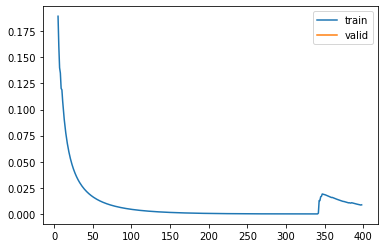

In [154]:
learn.recorder.plot_loss()

In [162]:
resnet_piece = resnet18(pretrained=True).to(device)
n = resnet_piece.fc.in_features
resnet_piece.fc = nn.Linear(n, 13)
summary(resnet_piece, x.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
       BatchNorm2d-2           [-1, 64, 25, 25]             128
              ReLU-3           [-1, 64, 25, 25]               0
         MaxPool2d-4           [-1, 64, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]          36,864
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
       BasicBlock-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]          36,864
      BatchNorm2d-13           [-1, 64, 13, 13]             128
             ReLU-14           [-1, 64,

In [163]:
learn_p = Learner(piece_sets, resnet_piece, opt_func = Adam,
                loss_func = celoss, metrics = accuracy)

learn_p.freeze()

In [164]:
learn_p.fit(1, .001)

epoch,train_loss,valid_loss,accuracy,time
0,0.016619,0.004635,0.998867,57:34


In [165]:
learn_p.path = Path(module_dir)
learn_p.export('piece_model.pkl')

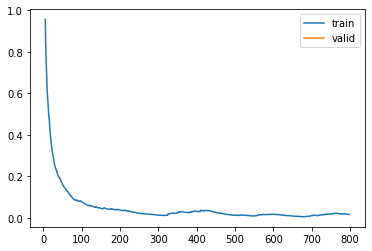

In [166]:
learn_p.recorder.plot_loss()

## Testing

In [18]:
def recollectFEN(testnum):

  flatFEN = ['_'] * 64
  cur = 0
  for i in range(0, 8):
    for j in range(0, 8):
      flatFEN[cur] = re.search('test/(.+)_(.+)_(.+?).jpg', labeledtestdata[testnum*64 + i*8 + j]).group(3)
      cur += 1

  return flatFEN

In [22]:
learn_occ = load_learner(os.path.join(module_dir, 'occ_model.pkl'))
learn_piece = load_learner(os.path.join(module_dir, 'piece_model.pkl'))

In [51]:
db_occ = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                   get_items = get_image_files,
                   get_y = occ_func,
                   splitter = RandomSplitter())

In [82]:
dls_occ = db_occ.dataloaders(test_dir)
test_occ = dls_occ.test_dl(labeledtestdata, with_labels=True)

In [86]:
test_files = get_image_files(test_dir)
test_occ = dls_occ.test_dl(test_items = test_files, with_labels = True)

In [102]:
test_occ_logprobs, test_occ_targets = learn_occ.get_preds(dl = test_occ)

In [107]:
test_occ_loss, test_occ_acc = learn_occ.validate(dl = test_occ)

In [105]:
test_occ_preds = test_occ_logprobs.argmax(axis = 1)

In [106]:
print(test_occ_targets)
print(test_occ_preds)

TensorCategory([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


In [132]:
results_occ = [True] * 500
for i in range(0, 500):
  for j in range(0, 64):
    if(test_occ_preds[i*64 + j] != test_occ_targets[i*64 + j]):
      results_occ[i] = False
      break

In [135]:
occ_inc_cnt = 0
for i in results_occ:
  if i == False:
    occ_inc_cnt += 1

print("occupants incorrectly identified:",occ_inc_cnt)

occupants incorrectly identified: 0


All square occupancies properly identified

Testing of piece classifier

In [118]:
db_piece = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                   get_items = get_image_files,
                   get_y = piece_func,
                   splitter = RandomSplitter())
dls_piece = db_piece.dataloaders(test_dir)
test_files = get_image_files(test_dir)
test_piece = dls_piece.test_dl(test_items = test_files, with_labels = True)

In [120]:
test_piece_logprobs, test_piece_targets = learn_piece.get_preds(dl = test_piece)
test_piece_loss, test_piece_acc = learn_piece.validate(dl = test_piece)
test_piece_preds = test_piece_logprobs.argmax(axis = 1)

In [122]:
results_piece = [True] * 500
for i in range(0, 500):
  for j in range(0, 64):
    if(test_piece_preds[i*64 + j] != test_piece_targets[i*64 + j]):
      results_piece[i] = False
      break

In [136]:
piece_inc_cnt = 0
for i in range(len(results_piece)):
  if results_piece[i] == False:
    piece_inc_cnt += 1
    print(i)

print('\nFENs incorrectly identified:', piece_inc_cnt)
print("accuracy:", (500-piece_inc_cnt)/500)

67
99
106
160
174
206
211
261
339
349
409
495

FENs incorrectly identified: 12
accuracy: 0.976


testnum: 67  tile: 25    prediction: n  actual: N
testnum: 99  tile: 39    prediction: _  actual: b
testnum: 106  tile: 61    prediction: Q  actual: K
testnum: 160  tile: 13    prediction: B  actual: P
testnum: 160  tile: 54    prediction: q  actual: k
testnum: 174  tile: 47    prediction: b  actual: q
testnum: 206  tile: 9    prediction: b  actual: B
testnum: 211  tile: 15    prediction: q  actual: k
testnum: 261  tile: 28    prediction: _  actual: b
testnum: 339  tile: 40    prediction: b  actual: B
testnum: 349  tile: 8    prediction: n  actual: N
testnum: 349  tile: 27    prediction: b  actual: B
testnum: 409  tile: 15    prediction: n  actual: N
testnum: 495  tile: 54    prediction: p  actual: P

Total Errors: 14


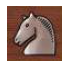

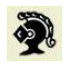

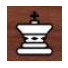

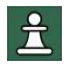

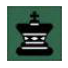

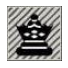

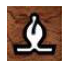

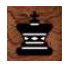

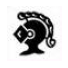

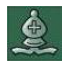

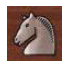

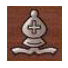

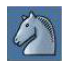

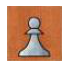

In [151]:
tot_cnt = 0
for i in range(0, 500):
  for j in range(0, 64):
    if(test_piece_preds[i*64 + j] != test_piece_targets[i*64 + j]):
      tot_cnt += 1
      img = PILImage.create(labeledtestdata[i*64 + j])
      img.show()
      print("testnum:",i, " tile:", j + 1, 
            "   prediction:", test_piece.vocab[test_piece_preds[i*64 + j]],
            " actual:", test_piece.vocab[test_piece_targets[i*64 + j]])

print('\nTotal Errors:', tot_cnt)